## Render Tempest Strings

In [15]:
from itertools import groupby
from operator import itemgetter
from matplotlib import pyplot as plt
from PIL import Image, ImageColor, ImageDraw
import os

plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 150

def convert_black_to_transparent(img, tolerance=20):
    # Open the image and ensure it's in RGBA mode to handle the alpha channel
    img = img.convert("RGBA")
    datas = img.getdata()

    new_data = []
    # Define the target color (black) and the replacement color (transparent)
    target_color = (tolerance, tolerance, tolerance)
    transparent_color = (0, 0, 0, 0) # R, G, B, A (0 for full transparency)

    for item in datas:
        # Check if the pixel's RGB values match the target color
        if item[0] < target_color[0] and item[1] < target_color[1] and item[2] < target_color[2]:
            new_data.append(transparent_color)
        else:
            # Keep other pixels unchanged (including their existing alpha value, if any)
            new_data.append(item)

    img.putdata(new_data)
    return img

def plot_vertices(verts,file_name,points="",linewidth=3.0):
    # Plot a series of vertices onto a graph. In other words,
    # create an image from them.
    _, ax = plt.subplots()
    ax.set_aspect('equal', adjustable='box') 
    last_x,last_y=[],[]
    for k,g in groupby(verts, key=itemgetter(2)):
        l = list(g)
        xs,ys,_ =zip(*l)
        # Don't paint the vectors marked as black, 
        # we're just moving the beam.
        alpha = 0 if k == "BLACK" else 1
        ax.plot(xs,ys,points+'-',color=k,alpha=alpha,linewidth=linewidth)
    plt.savefig(f"literals/{file_name}.png", bbox_inches='tight')

def plot_vertices_imgonly(verts,file_name,points="",linewidth=3.0, color="white"):
    # Plot a series of vertices onto a graph. In other words,
    # create an image from them.
    _, ax = plt.subplots()
    ax.set_aspect('equal', adjustable='box') 
    last_x,last_y=[],[]
    for k,g in groupby(verts, key=itemgetter(2)):
        l = list(g)
        xs,ys,_ = zip(*l)
        # Don't paint the vectors marked as black, 
        # we're just moving the beam.
        alpha = 0 if k == "BLACK" else 1
        ax.plot(xs,ys,points+'-',color=color,alpha=alpha,linewidth=linewidth)
    plt.axis('off')
    image_file = f"strings/{file_name}.png"
    plt.savefig(image_file, bbox_inches='tight')
    img = Image.open(image_file)
    return img

In [2]:
colors = {
    "TURQOI":"CYAN",
    "PDIWHI":"WHITE",
    "PDIRED":"RED",
    "PDIYEL":"YELLOW",
    "":"WHITE",
}

def vctr(color,x,y,i=""):
    x,y = int(x,10),int(y,10)
    if i == "0":
        return (x,y,"BLACK")
    return (x,y,colors.get(color,color))

def parse_vector_commands(vector_data,default_color="red"):
    # Read in the vector commands from the Tempest source code
    # and translate them into a series of vectors, i.e. a  list of 
    # tuples of the form (x,y,color).
    # This list can then be transformed into a series of x,y co-ordinates
    # for plotting on a graph.
    color = ""
    vecs = []
    old_x,old_y = 0,0
    CALBRITE = "BLACK"
    for l in vector_data.splitlines():
        if not l.strip():
            continue
        tokens = l.strip().split()
        cmd, parms = tokens[0],tokens[1:]
        if cmd in ["ICVEC","ICALVE"]:
            vecs+=[(0,0,"BLACK")]
            old_x,old_y=0,0
        elif cmd == "VCTR":
            parms = parms[0].split(',')
            vecs+=[vctr(color,*parms)]
    return vecs

def vectors_to_coords(vectors):
    # Turns a series of vectors into a series of x,y co-ordinates
    # or vertices.
    xs,ys,cs=[],[],[]
    px,py,pc=0,0,None
    for x,y,c in vectors:
        # If we're changing color, add a vertex with the
        # new color at the old position.
        if pc and c != pc:
            xs+=[px]
            ys+=[py]
            cs+=[c]
        # Calculate the position of the new vertex
        px+=x
        py+=y
        xs+=[px]
        ys+=[py]
        cs+=[c]
        pc=c
    return list(zip(xs,ys,cs))



## Letter and Number Images from ANVGAN.MAC

This file contains the vectors for all alphanumerics. The values given are decimal rather than hexadecimal.

In [29]:
import re
anvgan = open("../tempest_fun/src/ANVGAN.MAC",'r').read()
letters = [tuple(x.split(':')) for x in re.split('CHAR\\.',anvgan)[1:28]]
letters = {x:y for x,y in letters}
letters[" "] = letters[""]
letters["©"] = """
	VCTR 0,4,0
	VCTR 0,16,.BRITE
	VCTR 4,4,.BRITE
	VCTR 8,0,.BRITE
	VCTR 4,-4,.BRITE
	VCTR 0,-16,.BRITE
	VCTR -4,-4,.BRITE
	VCTR -8,0,.BRITE
	VCTR -4,4,.BRITE
	VCTR 12,4,0
	VCTR -8,0,.BRITE
	VCTR 0,8,.BRITE
	VCTR 8,0,.BRITE
	VCTR 12,-16,0
"""

numbers = [tuple(x.split(':'))[:2] for x in re.split('CHAR\\.',anvgan)[30:39]]
for x,y in numbers:
    letters[x] = y
letters["0"]  = letters["O"]

In [60]:
def write_string(word, color):
    vector_data = "VCTR 0,0,0\n"
    for c in word:
        vector_data += letters[c]
    vectors = parse_vector_commands(vector_data)
    vertices = vectors_to_coords(vectors)
    img = plot_vertices_imgonly(vertices,f"{word}_black_",points="",color=color, linewidth=2.0)
    img = convert_black_to_transparent(img)
    img.save(f"strings/{word.replace(" ","_")}.png")

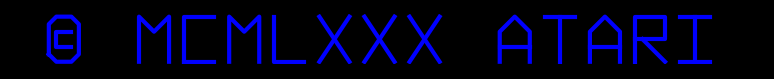

In [50]:
word = "© MCMLXXX ATARI"
color = "blue"
write_string(word,color)

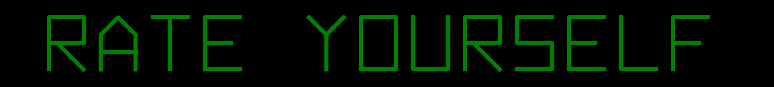

In [54]:
word = "RATE YOURSELF"
color = "green"
write_string(word,color)

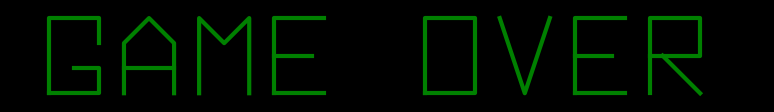

In [55]:
word = "GAME OVER"
color = "green"
write_string(word,color)

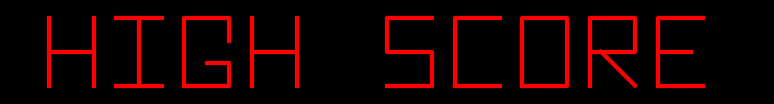

In [56]:
word = "HIGH SCORE"
color = "red"
write_string(word,color)

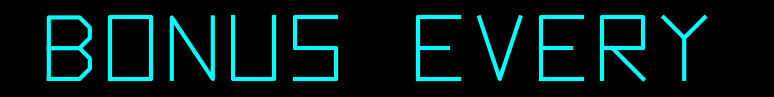

In [57]:
word = "BONUS EVERY"
color = "cyan"
write_string(word,color)

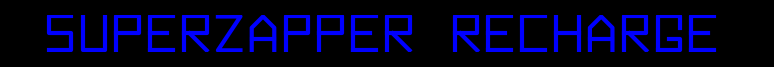

In [58]:
word = "SUPERZAPPER RECHARGE"
color = "blue"
write_string(word,color)

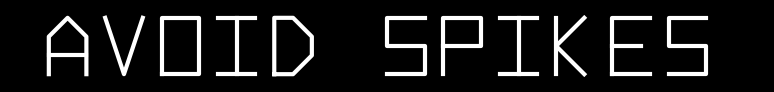

In [61]:
word = "AVOID SPIKES"
color = "white"
write_string(word,color)

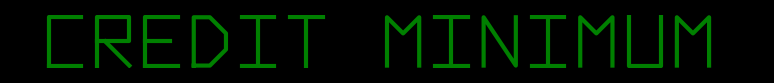

In [62]:
word = "CREDIT MINIMUM"
color = "green"
write_string(word,color)

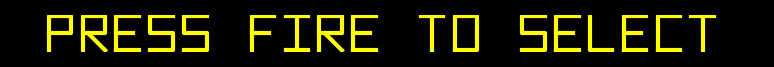

In [64]:
word = "PRESS FIRE TO SELECT"
color = "yellow"
write_string(word,color)

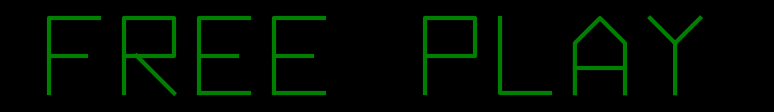

In [65]:
word = "FREE PLAY"
color = "green"
write_string(word,color)

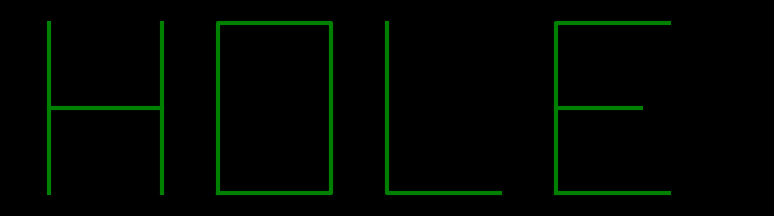

In [66]:
word = "HOLE"
color = "green"
write_string(word,color)

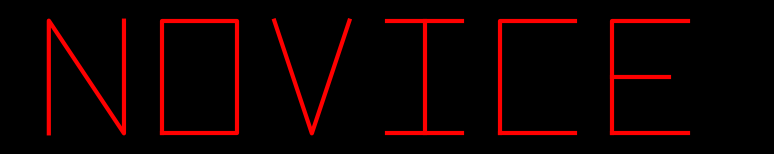

In [67]:
word = "NOVICE"
color = "red"
write_string(word,color)

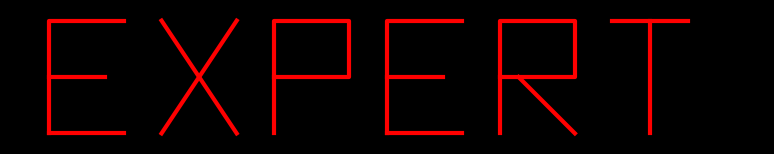

In [68]:
word = "EXPERT"
color = "red"
write_string(word,color)